# Transformada Cuantica de Fourier Aproximada con 2 rotaciones en Qiskit

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
IBMQ.save_account('b6a64fd92bc0d0f5af8011f1800820500e02cfafc29bb98e2c13c746b883ffa885b544d9e0d286cac28786d034872f25f77be296e88ac9e8bef093cb659536fb')

configrc.store_credentials:WARNING:2021-04-18 19:47:06,849: Credentials already present. Set overwrite=True to overwrite.


In [2]:
def aqft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    circuit.h(3)
    circuit.cp(pi/2**(1), 2, 3) # pasamos el numero, el qubit de control
                                            # y luego el objetivo.
    circuit.cp(pi/2**(2), 1, 3)
    
    circuit.barrier(3,2,1)
    
    circuit.h(2)
    circuit.cp(pi/2**(1), 1, 2)
    circuit.cp(pi/2**(2), 0, 2)
    circuit.barrier(2,1)
    
    circuit.h(1)
    circuit.cp(pi/2**(1), 0, 1)
    circuit.barrier(1,0)
    
    circuit.h(0)
    
    circuit.barrier(0)

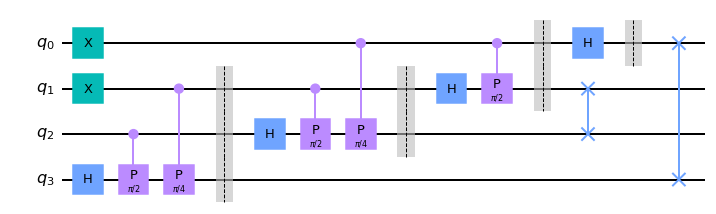

In [3]:
def swap_registers(circuit, n):
    for qubit in range(n//2): # tenemos que hacer el swap para queden bien 
        circuit.swap(qubit, n-qubit-1)
    return circuit

def aqft(circuit, n):
    """QFT on the first n qubits in circuit"""
    aqft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Hacemos para 4 qubits
qc = QuantumCircuit(4)
qc.x(0)
qc.x(1)
aqft(qc,4)
qc.draw('mpl')

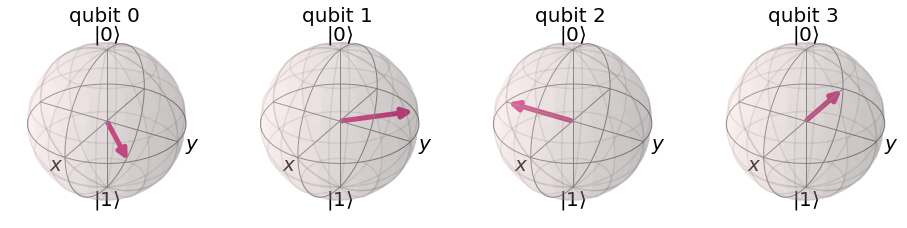

In [4]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

# Simulacion en Backen real

In [5]:
def inverse_aqft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = aqft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invaqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invaqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

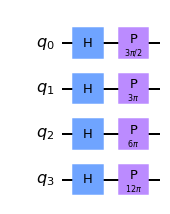

In [6]:
nqubits = 4
number = 12
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
    
qc.p(number*pi/8,0)
qc.p(number*pi/4,1)
qc.p(number*pi/2,2)
qc.p(number*pi/1,3)

qc.draw('mpl')

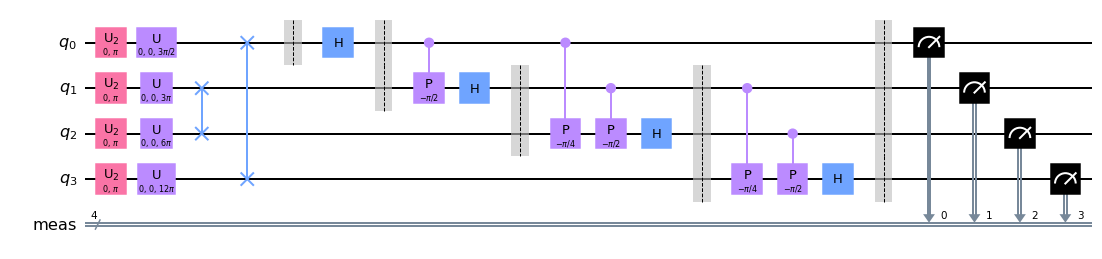

In [7]:
qc = inverse_aqft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

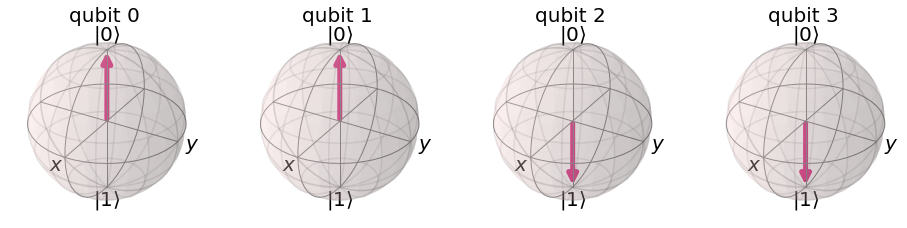

In [8]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

In [9]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_quito


In [110]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

Job Status: job has successfully run


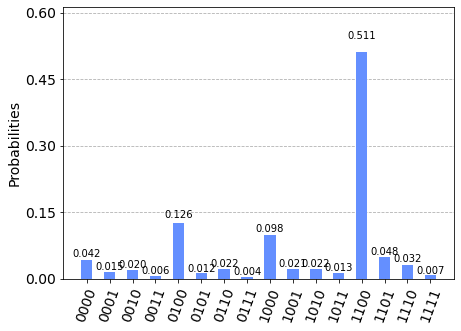

In [111]:
counts = job.result().get_counts()
plot_histogram(counts)

Como vemos, la probabilidad de la AQFT da un mejor resultado que en la QFT, ya que en QFT tiene mas puertas cuanticas, y eso provoca mas ruido.